import modules

In [15]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from shapely.geometry import Point
import requests
from zipfile import ZipFile
import os
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from sklearn.neighbors import BallTree

Get Weather Stations details available from Met Eireann :'https://cli.fusio.net/cli/climate_data/webdata/StationDetails.csv
And read into dataframe : wsdf, there are 2083 stations

In [5]:
wsdf = pd.read_csv('https://cli.fusio.net/cli/climate_data/webdata/StationDetails.csv')
wsdf.head

<bound method NDFrame.head of        county  station name                            name  height(m)  \
0      Antrim          5880                 LH_RATHLIN_WEST         10   
1      Carlow          4415             TULLOW (Waterworks)         76   
2      Carlow          2414                     BORRIS G.S.         85   
3      Carlow          1214          CARLOW (SUGAR FACTORY)         58   
4      Carlow           115             HACKETSTOWN RECTORY        182   
...       ...           ...                             ...        ...   
2078  Wicklow          9820                   M.LOUGH OULER        457   
2079  Wicklow          2415           GLEN IMAAL (For.Stn.)        213   
2080  Wicklow          2420             OLDBRIDGE (Oakview)        335   
2081  Wicklow          9915  M.GLEN IMAAL(BALLINABARNY FOR)        421   
2082  Wicklow          2424      ENNISKERRY (BALLYMAN HSE.)        107   

      easting  northing  latitude  longitude open year close year  
0      309200

The Values in 'open year' and 'close year' which describe the time range of recording for each staion are a combination of numeric text values and '(null)'
We want to analyse data from Weather Stations which have data from 2010 to the present
We'll convert the '(null)' to a future year '3000' and convert to int.
This allows us to filter the data based on Year and reduces the number of stations to 429

In [8]:
wsdf[['open year', 'close year']].replace(['(null)'], '3000')
#Change 'open year' and 'close year' to int
wsdf[['open year', 'close year']].astype(int)
#Filter Weather Stations to those reporting data from 2014 to the present
wsdf=wsdf.loc[(wsdf['close year'] == 3000) & (wsdf['open year'] < 2015)]
wsdf.shape

(429, 10)

Get a visual idea of the distribution of the stations by superimposing a plot of the stations on a map of Ireland(state) using this shape file from here https://www.geoboundaries.org/data/1_3_3/zip/shapefile/IRL/IRL_ADM1.shp.zip

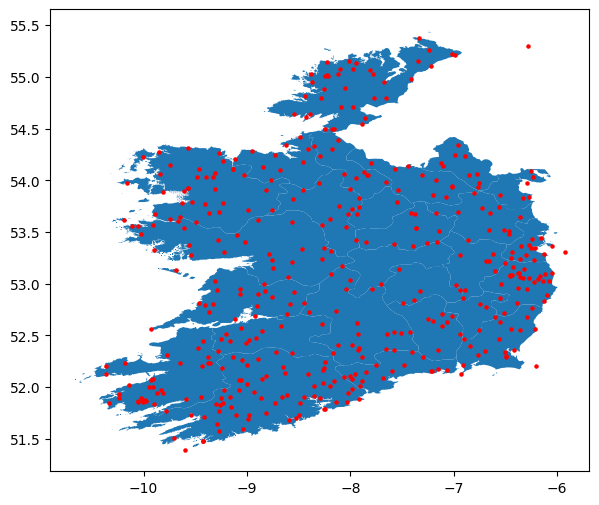

In [9]:
def stationinirelandplot(df):
    IRL_map= gpd.read_file('./IRL_adm/IRL_adm1.shp')
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    gdf = GeoDataFrame(wsdf, geometry=geometry) 
    gdf.plot(ax=IRL_map.plot(figsize=(10, 6)), marker='o', color='red', markersize=5);
stationinirelandplot(wsdf)

Remove Rathlin Island Station from dataframe as it is not in the state

In [11]:
wsdf = wsdf.loc[wsdf["name"] != 'LH_RATHLIN_WEST']
wsdf.shape

(428, 11)

For each of the stations, check if hourly data exists, if not drop it from the stations dataset, otherwise download the files to the zipped folder and unzip to the unzipped folder.
The files are named using the station name which is a number. For example the station name of ROCHES POINT is 1075 and the file to download is hly1075.zip. There are 25 staions remaining after this

In [ ]:
def validurl(url):
	try:
		get = requests.get(url)		 
		if get.status_code == 200:
			return True
		else:
			return False
	except requests.exceptions.RequestException as e:
		return False

baseurl='https://cli.fusio.net/cli/climate_data/webdata/hly'
basezipfile='./weatherstationdata/zipped/hly'
baseunzipfile=basezipfile.replace("zipped", "unzipped")
for station in wsdf['station name']:
    stationurl=baseurl+str(station)+'.zip'
    stationzipfile=basezipfile+str(station)+'.zip'
    stationzipfolder=stationzipfile[:-4]
    stationunzipfolder=stationzipfolder.replace("zipped", "unzipped")
    if validurl(stationurl):
        response = requests.get(stationurl)
        open(stationzipfile, "wb").write(response.content)
        with ZipFile(stationzipfile, 'r') as zip_ref:
                zip_ref.extractall(stationunzipfolder)
    else:
        wsdf = wsdf.loc[wsdf["station name"] != station]
stationinirelandplot(wsdf)

Get a distribution for the remaining stations. By finding the station's nearest neighbour and the distance between them using Balltree and Haversine method.
Distribution looks reasonably Ok, the distances are not significant

<Axes: ylabel='Density'>

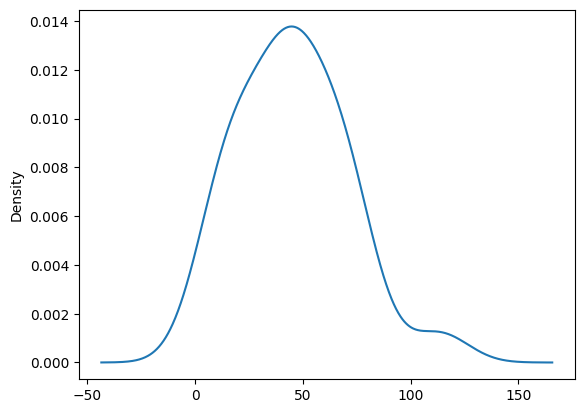

In [17]:
# convert the degrees to radians and store in the dataframe
wsdf[["latradian", "longradian"]] = np.deg2rad(wsdf[["latitude", "longitude"]])
ball_tree = BallTree(wsdf[["latradian", "longradian"]], metric="haversine")
distances,neighbours = ball_tree.query(
    wsdf[["latradian", "longradian"]],
    k=2,
    return_distance=True,
    sort_results=True,
)
#remove the nearwst neighbour and distance which is itself and 0
neighbours = neighbours[:, 1:]
distances = distances[:, 1:]

wsdf["nearest_stations"] = [
    wsdf["name"].iloc[n].to_list() for n in neighbours
]
wsdf["nearest_station_distance(rad)"] = distances
#convert distances to km
wsdf["nearest_station_distance(km)"] = distances*6371
wsdf.explode("nearest_stations")[["name", "nearest_stations"]]
#wsdf.to_csv('./weatherstationdata/stationinfo.csv')
#plot the distribution - Make this fancier
wsdf["nearest_station_distance(km)"].plot(kind='kde')

For each file in ./weatherstationdata/unzipped with the pattern hly*.csv - Use regex here
Find  'date:' and for each line until blank line create a dictionary for renaming the columns later
Find column headers starting with date, and check if there is a header called wdsp whic is Wind Speed, 
If there is then write the rest of the file into the processed folder
Rename the columns as per the dictionary
Delete unused columns
23 stations remain that have Windspeed data

In [18]:
import os
wdict={}
stationunziphomefolder = basezipfile[:-4].replace('zipped','unzipped')
for folder in os.listdir(stationunziphomefolder):
    weatherdatafile=stationunziphomefolder+'/'+folder+"/"+folder+'.csv'
    inblock=False
    with open(weatherdatafile, 'r') as wf:
        for lineno, line in enumerate(wf):
            if 'date:' in line or (inblock and line.strip()):
                inblock=True
                wdict[line.split(":")[0]] = line.split("-")[1].strip()
            else:
                if inblock:
                    break
    with open(weatherdatafile, 'r') as wf:
        for lineno, line in enumerate(wf):
                if 'date,' in line:
                    firstline = lineno
                    break 
    if (',wdsp' in line): 
        with open(weatherdatafile, 'r') as wf:
            for lineno, line in enumerate(wf):    
                lines=wf.readlines()   
        # Write file
        stationprochomefolder=stationunziphomefolder.replace('unzipped','processed')
        weatherdataprocfile=stationprochomefolder+"/"+weatherdatafile.split("/")[-1]
        with open(weatherdataprocfile, 'w') as wwf:
            # iterate each line
            for lineno, line in enumerate(lines):
                if lineno > (firstline-2):
                    wwf.write(line)
    else:
        print("Not Processing : "+folder)
        stationname=int(folder[3:])
        wsdf = wsdf.loc[wsdf["station name"] != stationname]
wsdf.shape

Not Processing : hly1275
Not Processing : hly175


(23, 16)

Check for missing values of in the dataset, using 
The data for 2013 is only partial, so that should be removed. 
## This step is out of order ##

In [ ]:
for k, v in wddf[wddf['wddir'] == ' '].groupby((wddf['wddir'] != ' ').cumsum()):
    print(f'[group {k}]')
    print(v['Datetime'].min())
    print(v['Datetime'].max())
    print(v.count())
    print('\n')

Read in the processed Weather Data file.
Clean and combine the Weather Data
For each file read into a dataframe 
Convert date column to datetime and rename as Datetime
Remove any rows not in the range 2014-01-01 - 2023-01-01
There are isolated rows with blank values, replace these with '0'
Convert wdsp to int
Add in to dataframe allwddf
There are 1814424 records
Remove the index and make Datetime the DatetimeIndex
Create a pivoted dataset : pivwddf, such that every station is a column with the windspeed at that datetime as the value.
Write pivwddf to csv file 
## Plot a sample of the data ##

C:\Users\czl\AppData\Local\Temp\ipykernel_32984\844255142.py:6: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  wddf = pd.read_csv(weatherdataprocfile)
C:\Users\czl\AppData\Local\Temp\ipykernel_32984\844255142.py:6: DtypeWarning: Columns (2,4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  wddf = pd.read_csv(weatherdataprocfile)
C:\Users\czl\AppData\Local\Temp\ipykernel_32984\844255142.py:6: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  wddf = pd.read_csv(weatherdataprocfile)
C:\Users\czl\AppData\Local\Temp\ipykernel_32984\844255142.py:6: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  wddf = pd.read_csv(weatherdataprocfile)
C:\Users\czl\AppData\Local\Temp\ipykernel_32984\844255142.py:6: DtypeWarning: Columns (2,6,7,8,9,12,14,15,16,17,18

<Axes: xlabel='Datetime'>

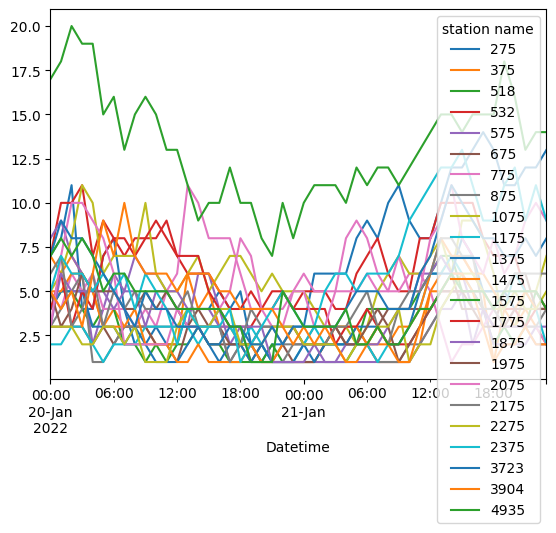

In [20]:
allwddf=pd. DataFrame()
startdate=pd.to_datetime('2014-01-01', format='%Y-%m-%d')
enddate=pd.to_datetime('2023-01-01', format='%Y-%m-%d')
for file in os.listdir(stationprochomefolder):
    weatherdataprocfile=stationprochomefolder+"/"+file
    wddf = pd.read_csv(weatherdataprocfile)
    wddf['Datetime'] = pd.to_datetime(wddf['date'], format='%d-%b-%Y %H:%M')
    mask = (wddf['Datetime']  >= startdate) & (wddf['Datetime'] < enddate)
    wddf = wddf.loc[mask]
    columns = list(wddf.columns.values)
    retaincolumns=["Datetime","wdsp"]
    wddf = wddf.loc[:, retaincolumns]
    wddf['station name'] = int(file[3:][:-4])
    #Quick and Dirty Data Cleansing, replace blanks with zero
    wddf['wdsp'] = wddf['wdsp'].replace(' ','0')
    wddf['wdsp'] = wddf['wdsp'].astype(int)
    allwddf=pd.concat([allwddf, wddf], axis=0,ignore_index=True)
    #break
allwddf.shape
allwddf.reset_index(drop=True)
allwddf = allwddf.set_index(pd.DatetimeIndex(allwddf['Datetime']))
pivwddf=allwddf.pivot(index="Datetime", columns="station name", values="wdsp")
pivwddf.to_csv('./weatherstationdata/wspivot.csv')
#Make this look good
pivwddf["2022-01-20":"2022-01-21"].plot()

Do a plot here

##  No Need to rerun - Download Job  ##
Download WindGeneration data for Ireland(state)
Get the Actual Wind Generation data from https://www.smartgriddashboard.com/DashboardService.svc
Last 3o days data available by using this url.
https://www.smartgriddashboard.com/DashboardService.svc/csv?area=windActual&region=ALL&datefrom=04-Feb-2023%2000:00&dateto=05-Mar-2023%2023:59

Crafting urls by manipulating the url parameters allows the possibility of downloading data for custom timeframes.
Attempting to download a full year resulted in an empty file
It was possible to download data in monthly chunks like so
https://www.smartgriddashboard.com/DashboardService.svc/csv?area=windActual&region=ROI&datefrom=01-Dec-2022%2000:00&dateto=31-Dec-2022%2023:59
Use the calendar and datetime libraries to get the first and last days of each month from 2013 to 2022 and inject these into the url to download the data

In [ ]:
import calendar
from datetime import datetime

baseurl="https://www.smartgriddashboard.com/DashboardService.svc/csv?area=windActual&region=ROI&datefrom="
separator="%2000:00&dateto="
end="%2023:59"
edfolder="./windgeneration/monthly/"
edfileprefix='WindGenerationROIMonthly'
edfileextension='.csv'

for year in range(2013,2023):
    for month in range(1, 13):
        input_dt = datetime(year, month, 1)
        datefrom=input_dt.strftime('%d-%b-%Y')
        res = calendar.monthrange(input_dt.year, input_dt.month)
        day = res[1]
        last_dt = datetime(year, month, day)
        dateto = last_dt.strftime('%d-%b-%Y')
        monthto=last_dt.strftime('%Y%m')
        url=baseurl+datefrom+separator+dateto+end
        edfile=edfolder+edfileprefix+monthto+edfileextension
        print(url)
        print(edfile)
        if validurl(url):
            response = requests.get(url)
            open(edfile, "wb").write(response.content)

Plot a sample of the data

In [ ]:
file="./windgeneration/monthly/WindGenerationROIMonthly202201.csv"
wgdf=pd.read_csv(file)

wgdf['datetime'] = pd.to_datetime(wgdf['DATE & TIME'], format='%d %B %Y %H:%M')
columns = list(wgdf.columns.values) 
wgdf.columns = wgdf.columns.str.strip()
wgdf.dtypes
plt.plot(wgdf['datetime'], wgdf['ACTUAL WIND(MW)'])

##  No Need to rerun - Processing Job  ##
Process the files and merge into Single Dataframe, write to file ./windgeneration/processed/WindGenerationROIAll.csv

In [ ]:
wgalldf=pd.DataFrame()
wgfolder="./windgeneration/monthly/"
wgfileprefix='WindGenerationROIMonthly'
wgfileextension='.csv'
wgprocessedfolder="./windgeneration/processed/"
wgprocessedfile='WindGenerationROIAll.csv'
for file in os.listdir(wgfolder):
    wgfile=wgfolder+file
    #print(wgfile)
    wgdf=pd.read_csv(wgfile)
    wgalldf=pd.concat([wgalldf, wgdf], axis=0,ignore_index=True)

columns = list(wgalldf.columns.values) 
wgalldf.columns = wgalldf.columns.str.strip()
wgalldf.drop_duplicates(subset=['DATE & TIME', 'ACTUAL WIND(MW)'],inplace = True)
wgalldf['Datetime'] = pd.to_datetime(wgalldf['DATE & TIME'], format='%d %B %Y %H:%M')

wgalldf.reset_index(drop=True) #
wgalldf['Datetime'] = pd.to_datetime(wgalldf['Datetime'])
wgalldf = wgalldf.drop(columns=['DATE & TIME', 'FORECAST WIND(MW)','REGION'])
cols = wgalldf.columns.tolist()
cols = cols[-1:] + cols[:-1]
wgalldf = wgalldf[cols]
wgalldf = wgalldf.set_index(pd.DatetimeIndex(wgalldf['Datetime']))
#Replace invalid values with '0'
wgalldf['ACTUAL WIND(MW)'] = wgalldf['ACTUAL WIND(MW)'].replace('-','0')
#Convert 'ACTUAL WIND(MW)' to int
wgalldf['ACTUAL WIND(MW)'] = wgalldf['ACTUAL WIND(MW)'].astype('int')
#Replace negative values with positive counterparts, seems to be a data entry error after visual inspection
wgalldf['ACTUAL WIND(MW)'] = np.where(wgalldf['ACTUAL WIND(MW)'] < 0,
                                      wgalldf['ACTUAL WIND(MW)'] * -1,
                                      wgalldf['ACTUAL WIND(MW)'])
#Reduce Sample Size from Quarter Hourly to hourly, use the mean for the hour as the new value
wgalldf = wgalldf.resample("H").max()

wgalldf.to_csv('./windgeneration/windgen2014-2022.csv')
wgalldf.head
#[78888 rows x 2 columns]>
#wgalldf.dtypes

Merge the Wind Speed and Windgeneration data

In [ ]:
windall = pivwddf.join(wgalldf, how='outer')
windall.drop('Datetime', axis=1, inplace=True)
windall.dtypes